# Polynomial Regression
As shown in our report, given data `data` = $\{(x_1, y_1),\dots, (x_n, y_n)\}$, we calculate $X$ given as
\begin{equation}
X = \begin{bmatrix}
		1      & x_1    & \dots  & x_1^m  \\
		1      & x_2    & \dots  & x_2^m  \\
		\vdots & \vdots & \ddots & \vdots \\
		1      & x_n    & \dots  & x_n^m
	\end{bmatrix}
\end{equation}
If we have $k$ features then our $X$ changes to
\begin{equation}
	X = \begin{bmatrix}
		1 & x_{11} & \dots & x_{1k} & x_{11}^2 & \dots & x_{1k}^2 & \dots \\
		1 & x_{21} & \dots & x_{2k} & x_{2k}^2 & \dots & x_{2k}^2 & \dots \\
		\vdots & \vdots  & \ddots & \vdots & \vdots & \ddots & \vdots & \ddots\\
		1 & x_{n1} & \dots & x_{nk} & x_{nk}^2 & \dots & x_{nk}^2 & \dots
	\end{bmatrix}
\end{equation}


Then we have our estimate (our final answer) of $B$ as
\begin{equation}
B = (X^TX)^{-1}X^TY
\end{equation}
    

Importing all the required modules: `numpy`, `matplotlib`, `pandas` and the
training data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pickle # for pkl file
import pandas as pd
data = np.genfromtxt("train.csv",
                        delimiter=",",
                        skip_header=1,
                        usecols=(1,2))

In [25]:
class Regression:
    def __init__(self, data):
        self.data = data
        self.x = data[:, 0]
        self.Y = data[:, 1]
        self.k = 1
        self.m = None
        self.B = None
        self.test_data = None
        self.test_x = None
        self.test_X = None
        self.test_Y = None


    # Calculates the parameters B and stores it in self.B
    def fit(self, m):
        self.m = m
        self.k = 1 if len(self.x.shape) == 1 else self.x.shape[1]
        # calculates X from [x_1, x_2, ..., x_n]
        if self.k == 1:
            X = np.vstack([np.ones_like(self.x)] + 
                          [self.x ** i for i in range(1, self.m + 1)]).T
        else:
            print("this is running")
            n_samples, n_features = self.x.shape
            features = [np.ones(n_samples)]

            for i in range(n_features):
                features.append(self.x[:, i])

            for degree in range(2, self.m + 1):
                for i in np.ndindex(*(n_features,) * degree):
                    term = np.ones(n_samples)
                    for index in i:
                        term *= self.x[:, index]
                    features.append(term)
            
            X = np.vstack(features).T

        # B = (X^T X)^-1 X^T y
        self.B = np.linalg.inv(X.T @ X) @ X.T @ self.Y
    

    # Returns SSR for a given data using the parameters stored
    def get_ssr(self, test_data):
        self.test_data = test_data
        self.test_x = test_data[:, 0]
        self.test_Y = test_data[:, 1]
        self.test_X = np.vstack([np.ones_like(self.test_x)] + 
                                [self.test_x**i for i in range(1, self.m + 1)]).T
        if self.k == 1:
            self.test_X = np.vstack([np.ones_like(self.test_x)] + 
                          [self.test_x ** i for i in range(1, self.m + 1)]).T
        else:
            n_samples, n_features = self.test_x.shape
            features = [np.ones(n_samples)]

            for i in range(n_features):
                features.append(self.test_x[:, i])

            for degree in range(2, self.m + 1):
                for i in np.ndindex(*(n_features,) * degree):
                    term = np.ones(n_samples)
                    for index in i:
                        term *= self.x[:, index]
                    features.append(term)
            
            self.test_X = np.vstack(features).T

        return np.sum(((self.test_Y - self.test_X @ self.B) ** 2))


    # Returns the predicted values for a given data, using the parameters stored
    def evaluate(self, x):
        return np.sum([x**i * self.B[i] for i in range(0, self.m+1)], axis=0)


    # Returns SSRs over a given range(it) of degrees for a given data
    def get_ssrs_vs_m(self, given_data, it):
        ssrs = np.array([])
        for i in it:
            self.fit(i)
            ssrs = np.append(ssrs, self.get_ssr(given_data))
        return ssrs

    
    # Returns R^2 over a given range(it) of degrees for a given data
    def get_r2s_vs_m(self, given_data, it):
        r2s = np.array([])
        for i in it:
            self.fit(i)
            ss_y = np.sum((self.test_data[:, 1] - np.mean(self.test_data[:, 1])) ** 2)
            r2s = np.append(r2s, 1 - self.get_ssr(given_data)/ss_y)
        return r2s

For testing data, we have
\begin{equation}
    SS_R = \text{sum}(Y-XB)^2
\end{equation}
Where squaring is just individual term squaring. Sum is sum of all elements of
matrix

A good idea is to divdie our given `data` into training (`train_data`) and
testing data (`test_data`). The way we do this actually matters but I'm going to
take a random 10% of the data. But there's a possibility of getting a bias
based on what 10% you're choosing.

Here's a better idea:
- Divide the given data into 10 equal segments randomly
- For each segment, train on the remaining 9 segments
- With the parameters you obtain, test on this segment
- You'll get the $SS_R$, for each segment. Take the mean of these.

Note: We're comparing the errors based on $SS_R$

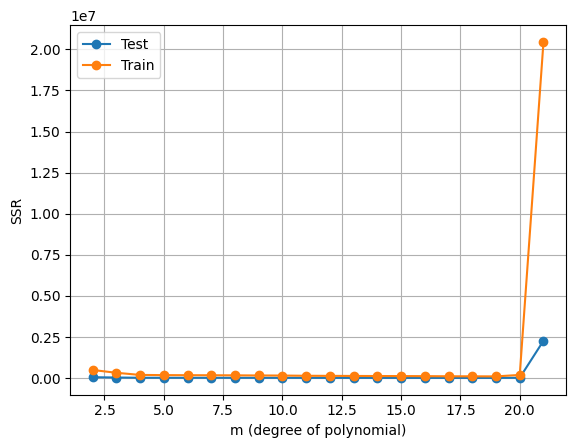

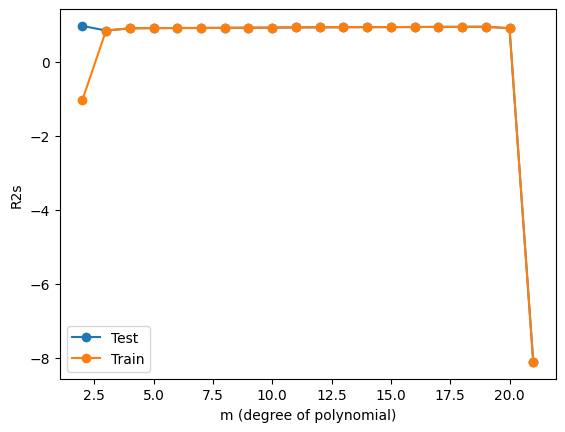

In [26]:
# shuffling the data
all_possible_indices = np.arange(data.shape[0])
np.random.seed(60)
np.random.shuffle(all_possible_indices)

# taking indices
num_segments = 10
indices_segments = np.array_split(all_possible_indices, num_segments)
data_segments = np.array([data[segment] for segment in indices_segments])

m_range = range(2, 22)

# to store ssrs, r2s after testing on each segment
test_ssrs_vs_m = list()
train_ssrs_vs_m = list()
test_r2s_vs_m = list()
train_r2s_vs_m = list()
Bs = list()

# testing on each segment
for i, segment in enumerate(data_segments):
    test_data = segment
    train_data = np.concatenate([data_segments[i] for j in
                                range(len(data_segments)) if j != i])

    regressor = Regression(train_data)

    test_ssr_vs_m = regressor.get_ssrs_vs_m(test_data, m_range)
    test_ssrs_vs_m.append(test_ssr_vs_m)      
    train_ssr_vs_m = regressor.get_ssrs_vs_m(train_data, m_range)
    train_ssrs_vs_m.append(train_ssr_vs_m)      

    test_r2_vs_m = regressor.get_r2s_vs_m(test_data, m_range)
    test_r2s_vs_m.append(test_r2_vs_m)      
    train_r2_vs_m = regressor.get_r2s_vs_m(train_data, m_range)
    train_r2s_vs_m.append(train_r2_vs_m)      
    
    pass

# averaging the ssrs, r2s over all segments
test_ssrs_vs_m = np.sum(np.array(test_ssrs_vs_m), axis=0) / len(data_segments)
train_ssrs_vs_m = np.sum(np.array(train_ssrs_vs_m), axis=0) / len(data_segments)
test_r2s_vs_m = np.sum(np.array(test_r2s_vs_m), axis=0) / len(data_segments)
train_r2s_vs_m = np.sum(np.array(train_r2s_vs_m), axis=0) / len(data_segments)

# plotting SSRs
plt.grid(True)
plt.xlabel("m (degree of polynomial)")
plt.ylabel("SSR")
plt.plot(m_range, test_ssrs_vs_m, label="Test", marker="o")
plt.plot(m_range, train_ssrs_vs_m, label="Train", marker="o")
plt.legend()
plt.show()

# plotting R2s
plt.xlabel("m (degree of polynomial)")
plt.ylabel("R2s")
plt.plot(m_range, test_r2s_vs_m, label="Test", marker="o")
plt.plot(m_range, train_r2s_vs_m, label="Train", marker="o")
plt.legend()

## Part (a)

By the SSR graph above, $m=18$ seems to be the optimal degree of the polynomial.
Thus, polynomial regressor of degree 18 would be the best fit regressor for this
data. Let's calculate $\beta_0, \dots, \beta_{18}$ for this by fitting
polynomial regression onto our data.

Let's also write the test set predictions in the `3_predictions.csv` in the 
format:

id, x, y(predicted)

In [27]:
optimal_regressor = Regression(data)
optimal_regressor.fit(18)
print("Optimal B: ", optimal_regressor.B)
with open('3_weights.pkl', 'wb') as f:
    pickle.dump(optimal_regressor.B, f)

given_test_data = pd.read_csv('test.csv')
ids = given_test_data['id'].values
x_vals = given_test_data['x'].values

x_test = np.vstack(x_vals).T
# print(x_test)
y_pred = optimal_regressor.evaluate(x_test).flatten()
# print(x_test.shape, y_pred.shape)

predicitions = pd.DataFrame({'id': ids, 'x' : x_vals, 'y': y_pred})
predicitions.to_csv('3_predictions.csv', index=False)

Optimal B:  [ 8.75662398e+01  2.25315650e+01 -1.97083939e+01 -8.91599223e+01
  1.06174216e+02  1.12370064e+02 -1.32613117e+02 -8.05554700e+01
  8.49127870e+01  3.22148280e+01 -3.10624102e+01 -7.40687355e+00
  6.67492355e+00  9.70920758e-01 -8.29865758e-01 -6.73099027e-02
  5.50959884e-02  1.91274181e-03 -1.50900501e-03]


## Part (b)

But the thing is SSRs values are too close so values close aren't too much of an
underfit/overfit (they're almost similar) We see that SSR at 2 and 21 have
comparatively high SSRs, so degree 2 can be considered as an underfit and degree
21 as an overfit. Here's the fit for underfit, optimal fit and overfit
respectively

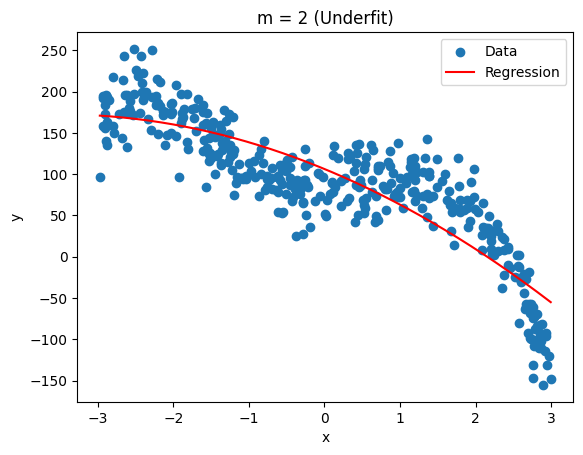

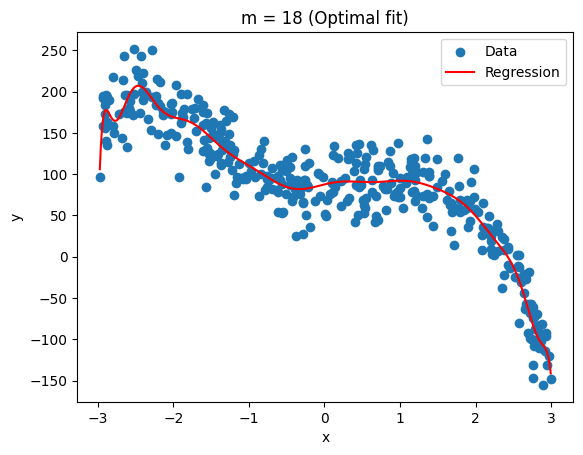

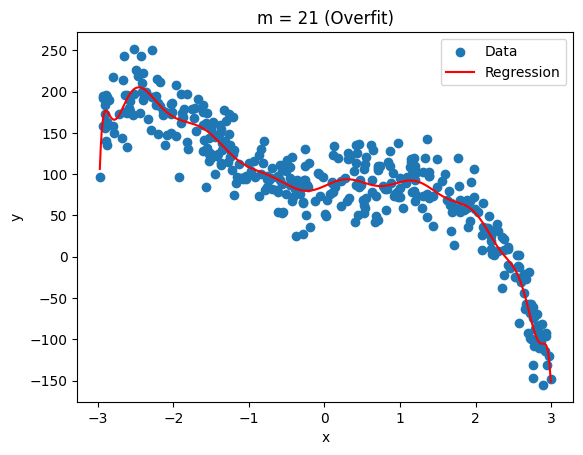

In [39]:
for m in [2, 18, 21]:
    regressor = Regression(data)
    regressor.fit(m)

    x = data[:, 0]
    y = data[:, 1]

    x_range = np.linspace(min(x), max(x), 1000)
    y_range = regressor.evaluate(x_range)

    fit = ""
    if m == 2:
        fit = "Underfit"
    elif m == 18:
        fit = "Optimal fit"
    else:
        fit = "Overfit"

    plt.figure()
    plt.scatter(x, y, label="Data")
    plt.plot(x_range, y_range, label="Regression", color="red")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"m = {m} ({fit})")
    plt.legend()
    plt.savefig(f"3_{fit}.png")
    plt.show()

## Part (c)

Finally, the $SS_R$ and $R^2$ for the solution presented, i.e a polynomial
regression model with degree $18$ is as follows:

In [40]:
optimal_ssr = optimal_regressor.get_ssr(data)
optimal_r2 = 1 - optimal_ssr / np.sum((data[:, 1] - np.mean(data[:, 1])) ** 2)

print(optimal_ssr, optimal_r2)

224592.60834798065 0.910251432520619
